<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/2_goingdeeper/01_nlp/%5BGD-06%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 06 : 임베딩 내 편향성 알아보기**

- **모든 장르 간 편향성 측정해보기**  

- **주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.**  
워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.  

- **영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.**  
타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.  

- **WEAT score 계산 및 시각화를 정상적으로 진행하였다.**  
전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

## **1. 데이터 준비**

### **1-1. 라이브러리 import**

In [1]:
import os
import pickle
from konlpy.tag import Okt
from gensim.models import Word2Vec

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

### **1-2. 데이터 import**

- **구글 드라이브 경로 mount**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- **데이터 import 및 확인**

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/synopsis/synopsis.txt', 'r') as file:
    for i in range(15):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

- **데이터 저장 함수**

In [4]:
def save_pkl(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

- **데이터 불러오기 함수**

In [5]:
def load_pkl(path):
    with open(path, "rb") as f:
        txt = pickle.load(f)
    return txt

## **2. Okt를 활용한 명사 추출**

### **2-1. 명사 추출 진행**

In [6]:
okt = Okt()
tokenized = []

with open('/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0]) 
        tokenized.append(res)

- **명사 파일 저장**

In [7]:
save_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/tokenized.pkl", tokenized)

### **2-2. 추출 데이터 확인**

- **명사 말뭉치 수 확인**

In [8]:
print('명사 말뭉치 수:', len(tokenized))

명사 말뭉치 수: 71156


- **명사 말뭉치 확인**

In [9]:
print(tokenized[:5])

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'], ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'], ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'], ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'], ['두', '사람', '날', '은수', '아파트', '밤']]


## **3. 임베딩 모델 생성**

### **3-1. 임베딩 벡터 생성**

In [10]:
model = Word2Vec(tokenized, vector_size = 100, window = 5, min_count = 3, sg=0)

### **3-2. 임베딩 학습 확인**

In [11]:
model.wv.most_similar(positive = ['영화'])

[('작품', 0.8873367309570312),
 ('다큐멘터리', 0.8489024043083191),
 ('드라마', 0.8300775289535522),
 ('영화로', 0.8152167201042175),
 ('시대극', 0.8074594736099243),
 ('코미디', 0.7828918695449829),
 ('주제', 0.7805544137954712),
 ('감동', 0.7789450883865356),
 ('형식', 0.7765981554985046),
 ('에마데딘', 0.772303581237793)]

In [12]:
model.wv.most_similar(positive = ['사랑'])

[('애정', 0.6996840238571167),
 ('첫사랑', 0.6903075575828552),
 ('만남', 0.686606764793396),
 ('감정', 0.6822546124458313),
 ('진심', 0.6795637607574463),
 ('행복', 0.6774492859840393),
 ('만인', 0.6760797500610352),
 ('이별', 0.6739864945411682),
 ('우정', 0.6710056662559509),
 ('운명', 0.6682238578796387)]

In [13]:
model.wv.most_similar(positive = ['눈물'])

[('미소', 0.9154207706451416),
 ('용기', 0.8999515771865845),
 ('문득', 0.8946699500083923),
 ('웃음', 0.8908260464668274),
 ('천사', 0.8904014825820923),
 ('어쩌면', 0.8901754021644592),
 ('아주', 0.8892539739608765),
 ('때론', 0.8884966373443604),
 ('부재', 0.885429322719574),
 ('진정', 0.8840643167495728)]

In [14]:
model.wv.most_similar(positive = ['행복'])

[('기쁨', 0.9101700186729431),
 ('슬픔', 0.891323983669281),
 ('좌절', 0.8900554776191711),
 ('한구석', 0.8686675429344177),
 ('용기', 0.8656827807426453),
 ('아픔', 0.8590744137763977),
 ('진정', 0.8575531840324402),
 ('위안', 0.8554707765579224),
 ('눈물', 0.8488653898239136),
 ('기적', 0.8472640514373779)]

## **4. WEAT Target 단어 선정**

### **4-1. 예술 영화 및 일반 영화 명사 추출**

In [17]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [18]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/synopsis/'+ file_name, 'r') as fread:
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem = True, norm = True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [19]:
art = read_token(art_txt)
gen = read_token(gen_txt)

In [20]:
save_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/art_word.pkl", art)
save_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/general_word.pkl", gen)  

In [21]:
art = load_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/art_word.pkl")
gen = load_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/general_word.pkl")

### **4-2. 추출 명사 확인**

- **추출 명사 수 확인**

In [22]:
print("예술 영화 명사 수:", len(art))
print("일반 영화 명사 수:", len(gen))

예술 영화 명사 수: 620208
일반 영화 명사 수: 3014815


- **추출 단어 확인**

In [23]:
art[:100]

'사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로'

In [24]:
gen[:100]

'유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 '

### **4-3. TF-IDF 단어 선정**

- **TF-IDF 생성**

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

- **형태 확인**

In [26]:
print(X.shape)

(2, 41082)


In [27]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


- **단어 및 TF-IDF 값 출력 함수 생성**

In [28]:
def print_word_tf_idf(data, show_num):    
    for idx in range(show_num):
        voc = vectorizer.get_feature_names()[data[idx][0]]
        tf_idf = round(data[idx][1], 3)
        print(f"{voc}({tf_idf})", end = ", ")

- **단어 및 TF-IDF 값 출력**

In [29]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

In [30]:
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

In [31]:
w1.sort(key=lambda x: x[1], reverse = True)
w2.sort(key=lambda x: x[1], reverse = True)

- **예술 영화 대표 단어 및 TF-IDF값 출력**

In [32]:
print_word_tf_idf(w1, 70)

그녀(0.304), 자신(0.295), 시작(0.291), 위해(0.261), 사랑(0.255), 사람(0.234), 영화(0.156), 친구(0.151), 남자(0.134), 가족(0.112), 이야기(0.11), 마을(0.105), 사건(0.099), 마음(0.098), 세상(0.098), 아버지(0.095), 아이(0.094), 엄마(0.093), 모든(0.092), 여자(0.091), 대한(0.088), 서로(0.086), 과연(0.086), 다시(0.083), 시간(0.083), 아들(0.08), 소녀(0.077), 아내(0.073), 다른(0.071), 사이(0.069), 영화제(0.069), 세계(0.069), 사실(0.068), 하나(0.066), 점점(0.063), 남편(0.062), 감독(0.061), 여행(0.061), 인생(0.06), 발견(0.059), 모두(0.059), 순간(0.059), 우리(0.058), 가장(0.057), 마지막(0.054), 생활(0.054), 아빠(0.054), 모습(0.053), 통해(0.053), 죽음(0.052), 기억(0.052), 비밀(0.052), 학교(0.052), 음악(0.051), 한편(0.05), 소년(0.048), 생각(0.047), 도시(0.047), 명의(0.047), 사고(0.046), 결혼(0.046), 전쟁(0.046), 때문(0.046), 위기(0.046), 이제(0.044), 최고(0.044), 이자(0.044), 과거(0.043), 일상(0.043), 경찰(0.042), 

- **일반 영화 대표 단어 및 TF-IDF값 출력**

In [33]:
print_word_tf_idf(w2, 70)

자신(0.303), 그녀(0.288), 영화제(0.288), 위해(0.236), 사람(0.213), 시작(0.211), 국제(0.196), 영화(0.175), 친구(0.158), 사랑(0.156), 남자(0.145), 이야기(0.126), 대한(0.103), 서울(0.1), 여자(0.1), 사건(0.097), 남편(0.094), 아이(0.09), 가족(0.089), 아버지(0.089), 다른(0.081), 마을(0.077), 시간(0.076), 엄마(0.075), 아들(0.073), 모든(0.073), 단편(0.073), 마음(0.073), 사실(0.071), 다시(0.071), 세계(0.07), 모습(0.069), 작품(0.068), 통해(0.068), 생각(0.068), 서로(0.068), 세상(0.066), 발견(0.064), 감독(0.064), 아내(0.063), 관계(0.063), 소녀(0.062), 사이(0.062), 하나(0.059), 우리(0.058), 애니메이션(0.058), 때문(0.058), 여성(0.053), 죽음(0.05), 과연(0.05), 점점(0.05), 인간(0.049), 생활(0.049), 한편(0.049), 결혼(0.049), 상황(0.049), 모두(0.048), 기억(0.047), 명의(0.045), 소년(0.045), 여행(0.044), 가장(0.044), 간다(0.044), 순간(0.044), 이제(0.043), 도시(0.043), 비밀(0.043), 학교(0.042), 과거(0.042), 가지(0.041), 

- **TF-IDF 값 기준 단어 추출**  
값이 0.05 이상인 단어만 추출  

In [34]:
def get_limit_tf_idf(data, limit_tf_idf):
    for idx, (_, tf_idf) in enumerate(data):
        if tf_idf < limit_tf_idf:
            break
    return data[:idx]

In [35]:
limit_tf_idf = 0.05

In [36]:
slice_w1 = get_limit_tf_idf(w1, limit_tf_idf)
slice_w2 = get_limit_tf_idf(w2, limit_tf_idf)

- **대표 단어 수 확인**

In [37]:
print("예술 영화 대표 단어 수:", len(slice_w1))
print("일반 영화 대표 단어 수:", len(slice_w2))

예술 영화 대표 단어 수: 54
일반 영화 대표 단어 수: 49


- **단어 개수 통일**

In [38]:
slice_w1 = slice_w1[:49]

- **중복 단어 수집 함수**

In [39]:
def get_duplicated_data(data1, data2):
    set_data1 = set(value[0] for value in data1)
    set_data2 = set(value[0] for value in data2)

    duplicated_list = list(set_data1 & set_data2)
    return duplicated_list

In [40]:
dupl_list = get_duplicated_data(slice_w1, slice_w2)

In [41]:
dict_w1 = {key: value for key, value in slice_w1}
dict_w2 = {key: value for key, value in slice_w2}

- **중복 단어 확인**

In [42]:
for idx, token in enumerate(dupl_list):
    w1_value = dict_w1[token]
    w2_value = dict_w2[token]
    subtract_w1_w2 = w1_value - w2_value
    
    voc = vectorizer.get_feature_names()[token].center(4)
    
    print(f"{voc}(art: {w1_value:.3f}, normal: {w2_value:.3f}, art-genre: {subtract_w1_w2:.3f})", end =", ")

 마음 (art: 0.098, normal: 0.073, art-genre: 0.025),  아들 (art: 0.080, normal: 0.073, art-genre: 0.006),  시간 (art: 0.083, normal: 0.076, art-genre: 0.007), 이야기 (art: 0.110, normal: 0.126, art-genre: -0.017),  위해 (art: 0.261, normal: 0.236, art-genre: 0.025),  아이 (art: 0.094, normal: 0.090, art-genre: 0.004),  사건 (art: 0.099, normal: 0.097, art-genre: 0.001),  사이 (art: 0.069, normal: 0.062, art-genre: 0.008),  세계 (art: 0.069, normal: 0.070, art-genre: -0.001), 아버지 (art: 0.095, normal: 0.089, art-genre: 0.006),  다른 (art: 0.071, normal: 0.081, art-genre: -0.010),  영화 (art: 0.156, normal: 0.175, art-genre: -0.019),  발견 (art: 0.059, normal: 0.064, art-genre: -0.005),  여자 (art: 0.091, normal: 0.100, art-genre: -0.009),  서로 (art: 0.086, normal: 0.068, art-genre: 0.018),  통해 (art: 0.053, normal: 0.068, art-genre: -0.015),  하나 (art: 0.066, normal: 0.059, art-genre: 0.007), 영화제 (art: 0.069, normal: 0.288, art-genre: -0.219),  감독 (art: 0.061, normal: 0.064, art-genre: -0.003),  엄마 (art: 0.093, norma

- **중복 단어 수 확인**

In [43]:
print("중복 단어 수:", len(dupl_list))

중복 단어 수: 39


- **중복 단어 제외**

In [44]:
target_art = [vectorizer.get_feature_names()[token] for token, _ in slice_w1 if token not in dupl_list]
target_gen = [vectorizer.get_feature_names()[token] for token, _ in slice_w2 if token not in dupl_list]

- **최종 예술 영화 대표 단어 확인**

In [45]:
print("예술 영화 대표 단어:", target_art)

예술 영화 대표 단어: ['과연', '점점', '여행', '인생', '모두', '순간', '가장', '마지막', '생활', '아빠']


- **최종 일반 영화 대표 단어 확인**

In [46]:
print("일반 영화 대표 단어:", target_gen)

일반 영화 대표 단어: ['국제', '서울', '단편', '작품', '생각', '관계', '애니메이션', '때문', '여성', '죽음']


## **5. WEAT Attribute 단어 선정**

### **5-1. 장르별 명사 추출**

- **총 21개의 장르별 명사 추출**

In [47]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 'synopsis_adventure.txt', 
              'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

In [48]:
genre_name = ['SF', '가족', '공연', '공포/호러', '기타', '다큐멘터리','드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄','사극', '서부극/웨스턴', '성인물/에로', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [49]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [50]:
save_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/genre_word.pkl", genre)

In [51]:
genre = load_pkl("/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/06/genre_word.pkl")

### **5-2. 추출 명사 확인**

- **영화 분류 수 확인**

In [52]:
print('영화 분류 수:', len(genre))

영화 분류 수: 21


- **영화 분류 별 추출 단어 수 확인**

In [53]:
for idx in range(len(genre)):
    print(f"{genre_name[idx]}: {len(genre[idx])}")

SF: 65038
가족: 23821
공연: 24369
공포/호러: 170697
기타: 147570
다큐멘터리: 477808
드라마: 1124761
멜로로맨스: 300036
뮤지컬: 10424
미스터리: 46534
범죄: 87649
사극: 10583
서부극/웨스턴: 2719
성인물/에로: 133364
스릴러: 127030
애니메이션: 369758
액션: 342982
어드벤처: 29205
전쟁: 25786
코미디: 321161
판타지: 35443


### **5-3. TF-IDF 단어 선정**

- **TF-IDF 생성**

In [54]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

- **형태 확인**

In [55]:
print(X.shape)

(21, 42191)


- **각 장르별 단어 및 TF-IDF 값 출력**

In [56]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [57]:
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

In [58]:
for idx in range(len(w)):
    print_word_tf_idf(w[idx], 10)

위해(0.261), 자신(0.258), 지구(0.243), 시작(0.227), 사람(0.193), 인류(0.189), 인간(0.148), 미래(0.13), 우주(0.125), 그녀(0.115), 엄마(0.247), 아빠(0.226), 가족(0.203), 영화제(0.2), 자신(0.194), 위해(0.175), 친구(0.153), 아주르(0.151), 아버지(0.15), 시작(0.146), 오페라(0.267), 사랑(0.265), 토스카(0.214), 실황(0.205), 올레(0.165), 자신(0.163), 카바(0.147), 그녀(0.138), 공연(0.125), 오텔로(0.122), 시작(0.258), 위해(0.242), 사람(0.24), 자신(0.232), 친구(0.223), 그녀(0.222), 사건(0.187), 공포(0.165), 발견(0.148), 죽음(0.132), 영화제(0.51), 국제(0.395), 서울(0.356), 단편(0.309), 영화(0.149), 자신(0.146), 사람(0.136), 이야기(0.127), 그녀(0.119), 남자(0.102), 영화제(0.335), 영화(0.277), 다큐(0.232), 국제(0.228), 다큐멘터리(0.218), 사람(0.198), 이야기(0.173), 대한(0.158), 자신(0.149), 감독(0.147), 자신(0.294), 영화제(0.289), 그녀(0.277), 사람(0.203), 사랑(0.202), 영화(0.19), 위해(0.189), 시작(0.181), 국제(0.149), 남자(0.145), 그녀(0.47), 사랑(0.305), 자신(0.249), 시작(0.208), 남편(0.205), 남자(0.199), 여자(0.176), 사람(0.161), 친구(0.147), 섹스(0.143), 뮤지컬(0.256), 사랑(0.201), 에스메랄다(0.194), 그녀(0.177), 음악(0.168), 충무로(0.158), 모차르트(0.152), 영화(0.148), 토스카(0.144), 자신(0.14

- **TF-IDF 값 기준 단어 추출**  
값이 0.01 이상인 단어만 추출  

In [59]:
limit_tf_idf = 0.01

In [60]:
genre_dict = {}

In [61]:
for idx, tf_idf in enumerate(w):
    genre_dict[genre_name[idx]] = get_limit_tf_idf(tf_idf, limit_tf_idf)

- **중복 단어 확인**  
단어 중요도 차이가 0.1 이상일 경우 중복 단어 제외 (해당 단어에 * 표시)  

In [62]:
LIMIT_DIFF = 0.1

In [63]:
for idx_i in range(len(genre_dict)-1):
    g1_name = genre_name[idx_i]
    print(f"<{g1_name}>")
    
    for idx_j in range(idx_i + 1, len(genre_dict)):
        g2_name = genre_name[idx_j]
        dupl_list = get_duplicated_data(genre_dict[g1_name], genre_dict[g2_name])
        
        if dupl_list:
            dupl_dict = {}

            for token in dupl_list:
                g1_idx, _ = np.where(np.array(genre_dict[g1_name]) == token)
                g2_idx, _ = np.where(np.array(genre_dict[g2_name]) == token)

                g1_tf_idf = genre_dict[g1_name][g1_idx[0]][1]
                g2_tf_idf = genre_dict[g2_name][g2_idx[0]][1]

                diff_g1_g2 = g1_tf_idf - g2_tf_idf

                if abs(diff_g1_g2) >= LIMIT_DIFF:
                    if diff_g1_g2 > 0:
                        del genre_dict[g2_name][g2_idx[0]]
                    else:
                        del genre_dict[g1_name][g1_idx[0]]
                else:
                    del genre_dict[g1_name][g1_idx[0]]
                    del genre_dict[g2_name][g2_idx[0]]
                dupl_dict[token] = diff_g1_g2

            print(f"{g2_name}:", end=" ")
            
            for idx, (token, value) in enumerate(dupl_dict.items()):
                value = f"*{value:.3f}" if abs(value) >= LIMIT_DIFF else f"{value:.3f}"
                print(f"{vectorizer.get_feature_names()[token]}({value})", end=", ")
            print()
                
    print(end="\n\n")    

<SF>
가족: 여자(0.007), 마을(-0.084), 마음(-0.041), 슈퍼(0.018), 스파이(-0.014), 소식(-0.027), 매일(-0.019), 영화제(*-0.171), 교수(-0.008), 갑자기(0.024), 마이클(-0.002), 계속(0.023), 상자(0.005), 잠시(-0.011), 여행(0.006), 부천(-0.017), 이상(0.020), 무기(0.021), 아이(-0.060), 마주(0.000), 해결(0.002), 마지막(0.009), 계획(0.021), 상태(0.017), 나무(0.001), 찾기(0.009), 주니(-0.026), 희망(0.002), 역시(-0.002), 도시(0.003), 인생(-0.019), 사회(0.005), 바다(0.001), 상황(0.011), 마침내(0.007), 세계(0.083), 때문(0.004), 음모(0.042), 보호(0.004), 지금(0.008), 파워(-0.005), 지난(-0.000), 주변(-0.007), 연구(0.030), 도움(-0.006), 타고(0.007), 누구(0.004), 미래(*0.119), 발견(0.036), 대한(-0.024), 바로(0.008), 도착(0.005), 모두(-0.008), 모든(0.071), 정신(0.006), 기상(0.002), 학교(-0.079), 회사(-0.011), 그것(0.004), 신비(-0.000), 자기(-0.004), 그녀(-0.028), 과거(0.025), 강제(-0.000), 이야기(-0.043), 주인공(0.001), 사건(0.015), 세상(-0.008), 주장(-0.006), 사고(0.026), 처음(-0.003), 생각(-0.007), 가운데(0.003), 기억(0.030), 과연(-0.007), 만난(-0.002), 더욱(0.010), 무엇(-0.006), 우리(-0.012), 가장(-0.038), 모습(0.004), 아내(-0.019), 현실(0.020), 지역(0.009), 비밀(0.050), 과학(0.000

- **단어 개수 통일**  
각 장르별 대표 단어 수 5개로 통일  

In [64]:
min_num = 100
for value in genre_dict.values():
    if min_num > len(value):
        min_num = len(value)

In [65]:
genre_dict = {token: value[:min_num] for token, value in genre_dict.items()}

In [66]:
print("장르별 대표 단어 수:", min_num)

장르별 대표 단어 수: 5


- **각 장르별 최종 단어 출력**

In [67]:
attributes = []

In [68]:
for value in genre_dict.values():
    attributes.append([vectorizer.get_feature_names()[token] for token, _ in value])

In [69]:
for genre, tokens in genre_dict.items():
    print(genre)
    print_word_tf_idf(tokens, 5)
    print('\n')

SF
지구(0.243), 인류(0.189), 스타크(0.059), 리플리(0.058), 켈빈(0.055), 

가족
엄마(0.247), 아빠(0.226), 아주르(0.151), 낙타(0.117), 씨제이(0.108), 

공연
오페라(0.267), 실황(0.205), 올레(0.165), 오텔로(0.122), 리골레토(0.121), 

공포/호러
공포(0.165), 악령(0.098), 분홍신(0.035), 캠핑(0.029), 심령(0.025), 

기타
영화제(0.51), 서울(0.356), 단편(0.309), 뉴미디어(0.082), 실험영화(0.025), 

다큐멘터리
다큐(0.232), 다큐멘터리(0.218), 투쟁(0.051), 인디다큐페스티발(0.05), 문화(0.048), 

드라마
퀴어(0.019), 질문(0.012), 교사(0.012), 대구(0.011), 심사(0.01), 

멜로로맨스
미연(0.024), 펜션(0.024), 수진(0.023), 하숙집(0.023), 준석(0.021), 

뮤지컬
뮤지컬(0.256), 에스메랄다(0.194), 음악(0.168), 충무로(0.158), 모차르트(0.152), 

미스터리
랭던(0.048), 몰카(0.045), 거미숲(0.043), 종섭(0.037), 승호(0.033), 

범죄
한길수(0.086), 파푸아(0.046), 금고(0.045), 마샨(0.039), 철중(0.035), 

사극
조선(0.368), 신기전(0.147), 아가멤논(0.128), 루안(0.11), 하선(0.097), 

서부극/웨스턴
서부(0.308), 보안관(0.226), 벌린(0.195), 카우보이(0.183), 그레이프바인(0.166), 

성인물/에로
남편(0.322), 마사지(0.237), 관계(0.163), 정사(0.146), 유이(0.066), 

스릴러
사건(0.283), 영훈(0.026), 피해자(0.026), 혜영(0.023), 트래셔(0.022), 

애니메이션
애니메이션(0.475), 인디애니페스트(0.18),

## **6. WEAT을 활용한 편향성 측정**

### **6-1. WEAT 점수 연산 함수**

In [70]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [71]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

In [72]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

### **6-2. WEAT 점수 연산 결과 확인**

- **각 영화 장르의 편향도 측정 결과 확인**

In [73]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [74]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

In [75]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [76]:
for i in range(len(genre_name)-1):
    print(f"< {genre_name[i]} >")
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) >= 1.:
            print(f"{genre_name[i]} - {genre_name[j]}: {matrix[i][j]:.3f}")
    print("\n")

< SF >
SF - 공연: 1.099
SF - 기타: 1.302
SF - 다큐멘터리: 1.242
SF - 드라마: 1.244
SF - 뮤지컬: 1.081
SF - 사극: 1.008
SF - 애니메이션: 1.219


< 가족 >
가족 - 기타: 1.136
가족 - 드라마: 1.061
가족 - 애니메이션: 1.007


< 공연 >
공연 - 기타: 1.202
공연 - 다큐멘터리: 1.192
공연 - 사극: -1.065
공연 - 서부극/웨스턴: -1.026
공연 - 어드벤처: -1.130
공연 - 전쟁: -1.217


< 공포/호러 >
공포/호러 - 기타: 1.166
공포/호러 - 다큐멘터리: 1.091
공포/호러 - 드라마: 1.085
공포/호러 - 애니메이션: 1.031


< 기타 >
기타 - 드라마: -1.040
기타 - 멜로로맨스: -1.166
기타 - 뮤지컬: -1.011
기타 - 미스터리: -1.181
기타 - 범죄: -1.142
기타 - 사극: -1.363
기타 - 서부극/웨스턴: -1.387
기타 - 애니메이션: -1.318
기타 - 액션: -1.200
기타 - 어드벤처: -1.385
기타 - 전쟁: -1.354
기타 - 코미디: -1.110
기타 - 판타지: -1.216


< 다큐멘터리 >
다큐멘터리 - 뮤지컬: -1.234
다큐멘터리 - 미스터리: -1.033
다큐멘터리 - 사극: -1.231
다큐멘터리 - 서부극/웨스턴: -1.172
다큐멘터리 - 액션: -1.104
다큐멘터리 - 어드벤처: -1.225
다큐멘터리 - 전쟁: -1.314
다큐멘터리 - 코미디: -1.028
다큐멘터리 - 판타지: -1.134


< 드라마 >
드라마 - 멜로로맨스: -1.046
드라마 - 미스터리: -1.084
드라마 - 범죄: -1.028
드라마 - 사극: -1.348
드라마 - 서부극/웨스턴: -1.327
드라마 - 액션: -1.123
드라마 - 어드벤처: -1.332
드라마 - 전쟁: -1.307
드라마 - 코미디: -1.058
드라마 - 판타지: 

- **각 영화 장르의 편향도 측정 결과 시각화**

In [77]:
np.random.seed(0)

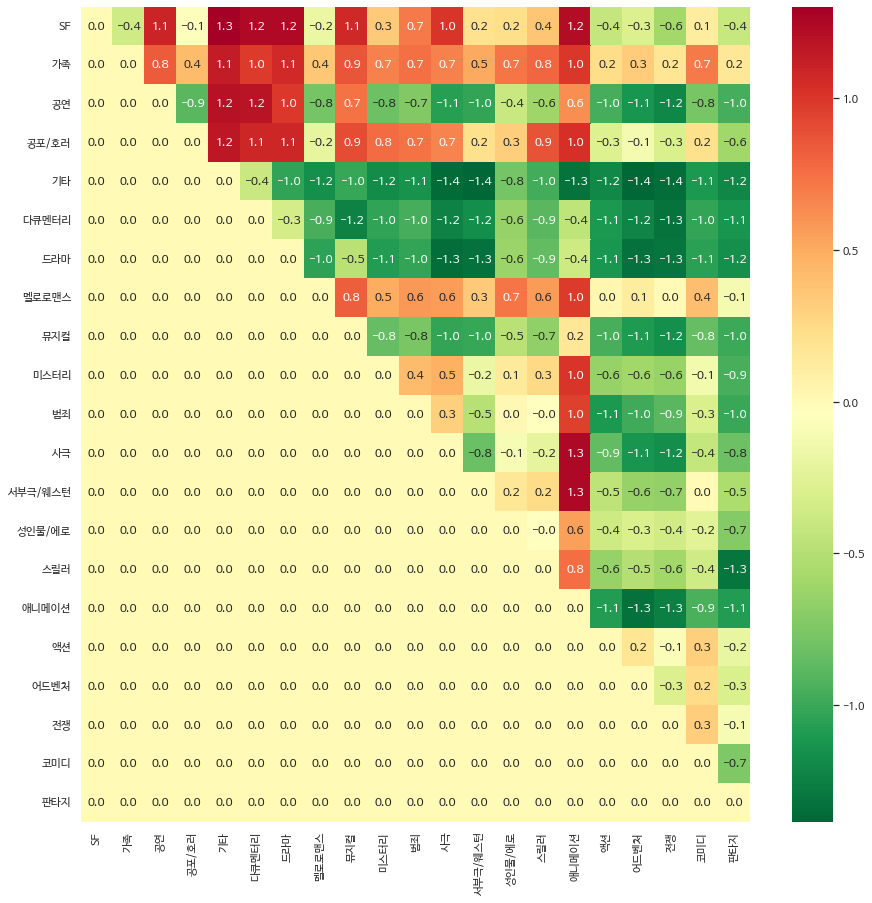

In [78]:
sns.set(font= 'NanumBarunGothic')

plt.figure(figsize=(15, 15))
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, fmt='.1f',  cmap='RdYlGn_r')
plt.show()

## **7. 회고**

### **7-1. 회고**

이번 프로젝트를 통해 편향성에 대해 알아보았는데, 이론 부분을 진행할 때 매우 흥미로운 주제로 다가왔다. 실제 프로젝트의 데이터의 경우, 성별이나 인종 등 논란의 여지가 크지 않은 데이터를 사용했기 때문에 그 부분을 두드러지게 확인하기는 어려웠지만 실제 단어간의 유사도를 통해 어느정도 비슷하게 분류하는지에 대해서는 알 수 있었다. 나의 생각보다는 대체적으로 편향되지 않은 공통된 주제어가 나와서 조금 아쉬웠고, 그렇기 때문에 실제로 모델에게 주어지는 데이터의 중요성이 좀 더 와닿았던 것 같다. 이번 프로젝트를 진행하면서 가장 어려웠던 부분은 매번 느끼는 부분이지만 한글 폰트를 깨지지 않고 넣는 방법이었다. 전에 WorldCloud를 사용하면서 한번 진행했던 적이 있는데, 그때는 문제 없이 잘 진행되었는데 이번에는 그렇지 않아서 여러번 시도를 진행했으나 마음만큼 잘 되지 않았다. 신기하게 커널을 다시 여러번 돌려보니 잘 될 때도 있어서 Colab 환경에서 작업할때는 항상 의구심이 든다. 요즘 진행한 프로젝트의 경우 대부분 오류가 없음에도 실행이 되었다 안되었다 해서 그런지 내가 잘 진행하고 있는지 판단이 어렵다. 파이썬은 다양한 라이브러리를 사용할 수 있는 간단한 구조여서 많이 쓰인다고 했는데, 그대신 버전 호환으로 인한 문제가 너무 자주 발생하는 것 같다. 그래서 개발자들이 좀 더 안정적인 리눅스 환경을 쓴다는 말이 이제 약간 이해가 된다. 계속해서 이런 문제를 만났을 경우 해결 할 수 있는 방안에 대해서 좀 더 공부가 필요하다고 생각한다.

### **7-2. 참고 자료**

1. https://github.com/eunji1/Aiffel/blob/main/NLP/NLP%5B06%5Dmovie_similar.ipynb
2. https://github.com/eunji1/Aiffel/blob/main/NLP/NLP%5B06%5Dmovie_similar.ipynb
3. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-06%5Dword_embedding_association_WEAT.ipynb